### Kepler Objects of Interest

This dataset is a comprehensive list of all confirmed exoplanets, planetary candidates, and false positives determined on all the transits captured by Kepler. Utilizing the variables in this labeled dataset could make for a solid method of performing supervised learning from different variables in the dataset. See column “Disposition Using Kepler Data” for classification.  
Explanation of each column name is in [the dataset](datasets/KOI.csv)

In [343]:
import pandas as pd 
url = 'datasets/KOI.csv'
kepler_df = pd.read_csv(url, comment='#')
kepler_df.head(5)

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [344]:
kepler_df.shape

(9564, 49)

Let's inspect missing values first.

In [345]:
kepler_df.isnull().sum().sort_values(ascending=False)


koi_teq_err2         9564
koi_teq_err1         9564
kepler_name          6817
koi_score            1510
koi_steff_err2        483
koi_srad_err2         468
koi_srad_err1         468
koi_slogg_err2        468
koi_slogg_err1        468
koi_steff_err1        468
koi_depth_err2        454
koi_impact_err2       454
koi_depth_err1        454
koi_duration_err2     454
koi_duration_err1     454
koi_impact_err1       454
koi_time0bk_err2      454
koi_time0bk_err1      454
koi_period_err2       454
koi_period_err1       454
koi_impact            363
koi_prad_err1         363
koi_srad              363
koi_slogg             363
koi_teq               363
koi_prad_err2         363
koi_prad              363
koi_depth             363
koi_steff             363
koi_model_snr         363
koi_tce_plnt_num      346
koi_tce_delivname     346
koi_insol             321
koi_insol_err1        321
koi_insol_err2        321
koi_kepmag              1
kepoi_name              0
koi_duration            0
koi_time0bk 

Columns ending with err can be dropped - these represent the measurement uncertainties. 'kepoi_name' and 'kepler_name' can also be dropped, as they only provide the name and nothing else that might be significant to our model ('kepid' will be left for now). 'koi_tce_delivname' will also be dropped, as this is Kepler's pipeline metadata. 'koi_pdisposition' and 'koi_score' will be dropped, as they are related to the initial judgement of the same KOI and would therefore disrupt the prediction of our model.
'koi_teq' and 'koi_insol' are basically the same information in different units - let's drop 'koi_teq'. 'koi_time0bk' can be dropped, as the time reference of transit does not influence the fact if the object is a planet or not. 

In [346]:
kepler_clean_df = kepler_df.drop(kepler_df.filter(regex="(_err1|_err2)$").columns, axis=1)
subset = ['kepoi_name', 'kepler_name', 'koi_pdisposition', 'koi_score', 'koi_tce_delivname', 'koi_teq', 'koi_time0bk']
kepler_clean_df = kepler_clean_df.drop(subset, axis=1)
kepler_clean_df.isnull().sum().sort_values(ascending=False)

koi_prad            363
koi_depth           363
koi_srad            363
koi_slogg           363
koi_steff           363
koi_model_snr       363
koi_impact          363
koi_tce_plnt_num    346
koi_insol           321
koi_kepmag            1
koi_disposition       0
koi_duration          0
koi_period            0
koi_fpflag_ec         0
koi_fpflag_co         0
koi_fpflag_ss         0
koi_fpflag_nt         0
ra                    0
dec                   0
kepid                 0
dtype: int64

The maximum number of missing values per column is now less than 4%, but before dropping these rows, let's extract the rows where the assigned label is CANDIDATE - as we do not know whether that is a confirmed exoplanet or a false positive, this would confuse our model without any increase in accuracy.

In [347]:
candidates_df = kepler_clean_df[kepler_clean_df["koi_disposition"].str.strip().str.upper() == "CANDIDATE"].copy()

labeled_df = kepler_clean_df[kepler_clean_df["koi_disposition"].str.strip().str.upper().isin(["CONFIRMED","FALSE POSITIVE"])].copy()

labeled_df["label"] = (
    labeled_df["koi_disposition"]
    .str.strip().str.upper()
    .map({"CONFIRMED": 1, "FALSE POSITIVE": 0})
)

labeled_df.drop(["koi_disposition"], axis=1, inplace=True)
labeled_df.head(5)


,kepid,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_impact,koi_duration,koi_depth,koi_prad,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag,label
0,10797460,0,0,0,0,9.488036,0.146,2.95750,615.8,2.26,93.59,35.8,1.0,5455.0,4.467,0.927,291.93423,48.141651,15.347,1
1,10797460,0,0,0,0,54.418383,0.586,4.50700,874.8,2.83,9.11,25.8,2.0,5455.0,4.467,0.927,291.93423,48.141651,15.347,1
3,10848459,0,1,0,0,1.736952,1.276,2.40641,8079.2,33.46,891.96,505.6,1.0,5805.0,4.564,0.791,285.53461,48.285210,15.597,0
4,10854555,0,0,0,0,2.525592,0.701,1.65450,603.3,2.75,926.16,40.9,1.0,6031.0,4.438,1.046,288.75488,48.226200,15.509,1
5,10872983,0,0,0,0,11.094321,0.538,4.59450,1517.5,3.90,114.81,66.5,1.0,6046.0,4.486,0.972,296.28613,48.224670,15.714,1


Let's check for missing values now

In [348]:
labeled_df.isnull().sum().sort_values(ascending=False)

koi_tce_plnt_num    286
koi_srad            259
koi_impact          259
koi_slogg           259
koi_depth           259
koi_prad            259
koi_steff           259
koi_model_snr       259
koi_insol           219
koi_kepmag            1
dec                   0
ra                    0
kepid                 0
koi_fpflag_nt         0
koi_duration          0
koi_period            0
koi_fpflag_ec         0
koi_fpflag_co         0
koi_fpflag_ss         0
label                 0
dtype: int64

In [349]:
labeled_df.dropna(inplace=True, axis=0)
labeled_df.isnull().sum()

kepid               0
koi_fpflag_nt       0
koi_fpflag_ss       0
koi_fpflag_co       0
koi_fpflag_ec       0
koi_period          0
koi_impact          0
koi_duration        0
koi_depth           0
koi_prad            0
koi_insol           0
koi_model_snr       0
koi_tce_plnt_num    0
koi_steff           0
koi_slogg           0
koi_srad            0
ra                  0
dec                 0
koi_kepmag          0
label               0
dtype: int64

Any further feature engineering (logarithmizing, creating new features etc.) will happen at later stages, as a measure to obtain the best model across various metrics.

The set is pretty much ready for analysis - further processing will be performed before each individual model, depending on its nature. I will evaluate the following models:  
- Logistic Regression
- K Neighbors Classifier
- Support Vector Machine
- Random Forest
- Gradient Boosting
- Histogram-based Gradient Boosting Classification Tree

As for metrics, the common approach in available papers was to maximize recall and precision. We'll set a threshold precision (e.g. above 0.90) and try to maximize recall for this precision. The primary metric will be PR AUC (area under the curve of precision-recall)

## Logistic Regression
Let's start with Logistic Regression. This will require scaling the data. We'll also group by koi_id - which is why we'll use GroupShuffleSplit. We'll perform cross-validation and grid search. 

In [350]:
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

drop = ["label", "kepid"]
feat_cols = [c for c in labeled_df.columns if c not in drop]
cont = ["koi_period", "koi_impact", "koi_duration", "koi_depth", "koi_prad", "koi_insol", "koi_model_snr", 
        "koi_steff", "koi_slogg", "koi_srad", "ra", "dec", "koi_kepmag"]
flags = ["koi_fpflag_nt", "koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec", "koi_tce_plnt_num"]

X = labeled_df[feat_cols]
y = labeled_df["label"]
groups = labeled_df["kepid"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]

preprocess = ColumnTransformer([
    ("scale", StandardScaler(), cont),
    ("pass", "passthrough", flags)
])

pipeline = Pipeline([
    ("preprocessing", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"))
])

C_l2 = np.logspace(-3, 3, 7)                 # 1e-3 … 1e3
C_l1 = [1e-3, 1e-2, 1e-1, 1, 10, 100]        # smaller cap for L1/EN

param_grid = [
    {
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"],
        "clf__C": C_l2,
        "clf__class_weight": [None, "balanced"],
        "clf__max_iter": [3000],
        "clf__tol": [1e-4, 1e-3],
    },
    {
        "clf__penalty": ["l1"],
        "clf__solver": ["liblinear"],
        "clf__C": C_l1,
        "clf__class_weight": [None, "balanced"],
        "clf__max_iter": [5000],
        "clf__tol": [1e-3],   
    },
    {
        "clf__penalty": ["elasticnet"],
        "clf__solver": ["saga"],
        "clf__l1_ratio": [0.1, 0.5, 0.9],
        "clf__C": [0.1, 1, 10],
        "clf__class_weight": [None, "balanced"],
        "clf__max_iter": [5000],
        "clf__tol": [1e-3],
    },
]

kf = GroupKFold(n_splits=5)
log_reg_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring="average_precision", cv=kf)
log_reg_cv.fit(X_train, y_train, groups=groups_train)

log_reg_best_model = log_reg_cv.best_estimator_ 
print("Best PR-AUC:", log_reg_cv.best_score_)
print("Best params:", log_reg_cv.best_params_)


Best PR-AUC: 0.9779207763817126
Best params: {'clf__C': 100, 'clf__class_weight': None, 'clf__max_iter': 5000, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'clf__tol': 0.001}


Let's check our model

In [351]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = log_reg_best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       900
           1       0.91      0.96      0.94       518

    accuracy                           0.95      1418
   macro avg       0.94      0.95      0.95      1418
weighted avg       0.95      0.95      0.95      1418

[[850  50]
 [ 19 499]]


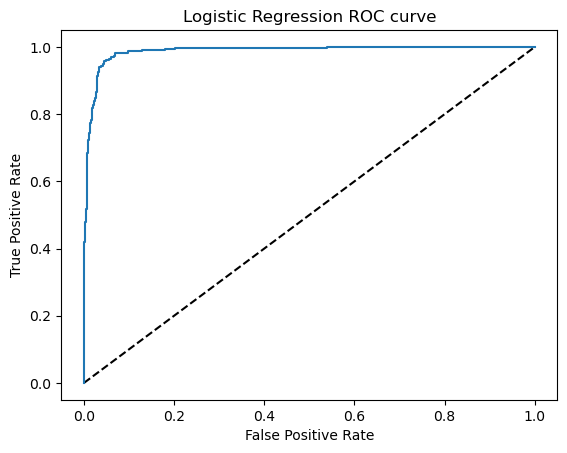

ROC-AUC score: 0.9873058773058773
Test PR-AUC (AP): 0.9762862695731223


In [352]:
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
y_pred_probabilities = log_reg_best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_probabilities)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC curve")
plt.show()
print("ROC-AUC score:", roc_auc_score(y_test, y_pred_probabilities))
print("Test PR-AUC (AP):", average_precision_score(y_test, y_pred_probabilities))

Let's try out different thresholds to find the highest recall for the precision>=0.90

In [353]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (y_pred_probabilities >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if p >= 0.90]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None 

print(f"Chosen threshold: {thr_star:.3f}  (Precision≥0.90)")
y_pred_thr = (y_pred_probabilities >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.380  (Precision≥0.90)
Precision/Recall/F1 @ thr: 0.9014336917562724 0.971042471042471 0.9349442379182156
[[845  55]
 [ 15 503]]


### Conclusion  
The highest recall when precision is above 0.90 (0.901) is 0.971. The test PR-AUC is 0.977. This means that the model is very good and reliable. Potential improvements include further data preprocessing (feature engineering, logarithmizing etc.)

## Random Forest  
Let's continue with a Random Forest. This is a model with a different base to the Logistic Regression model, so it might be combined with it to create an ensemble algorithm. Random Forest does not need scaling. We'll reuse the same train and test sets as for Logistic Regression

In [354]:
from sklearn.ensemble import RandomForestClassifier

preprocess_rf = ColumnTransformer([
    ("pass", "passthrough", cont + flags)
])

pipeline_rf = Pipeline([
    ("preprocessing", preprocess_rf),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid_rf = {
    "rf__max_depth": [None, 10],              
    "rf__min_samples_leaf": [1, 2, 4],         
    "rf__max_features": ["sqrt", 0.5],       
    "rf__class_weight": [None, "balanced_subsample"]
}

kf = GroupKFold(n_splits=5)
rf_cv = GridSearchCV(pipeline_rf, param_grid_rf, scoring="average_precision", cv=kf, n_jobs=-1, refit=True, verbose=1)
rf_cv.fit(X_train, y_train, groups=groups_train)

rf_best_model = rf_cv.best_estimator_
print("RF best PR-AUC (CV):", rf_cv.best_score_)
print("RF best params:", rf_cv.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
RF best PR-AUC (CV): 0.9992275490845375
RF best params: {'rf__class_weight': 'balanced_subsample', 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2}


Let's check our model

In [355]:
y_pred_rf = rf_best_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       900
           1       1.00      0.99      0.99       518

    accuracy                           0.99      1418
   macro avg       0.99      0.99      0.99      1418
weighted avg       0.99      0.99      0.99      1418

[[898   2]
 [  7 511]]


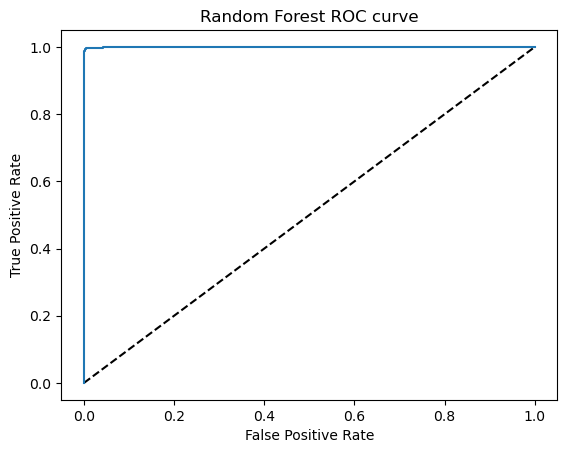

ROC-AUC score: 0.9998477048477048
Test PR-AUC (AP): 0.999746310194388


In [356]:
y_pred_rf_probabilities = rf_best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_rf_probabilities)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC curve")
plt.show()
print("ROC-AUC score:", roc_auc_score(y_test, y_pred_rf_probabilities))
print("Test PR-AUC (AP):", average_precision_score(y_test, y_pred_rf_probabilities))

In [357]:
thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (y_pred_rf_probabilities >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if p >= 0.90]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None 

print(f"Chosen threshold: {thr_star:.3f}  (Precision≥0.90)")
y_pred_thr = (y_pred_rf_probabilities >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.120  (Precision≥0.90)
Precision/Recall/F1 @ thr: 0.9040139616055847 1.0 0.9495875343721356
[[845  55]
 [  0 518]]


### Conclusion
We managed to obtain a model which achieves a recall of 1.00 - it means that the model correctly identified all confirmed planets in the test set - without omitting a single one. The PR-AUC is also very close to 1.000, which suggests an almost perfectly reliable model.

## Stacking - Logistic Regression + Random Forest  
Now that we have to models trained, let's try to combine their results to see if we can achieve an even better model. 

In [387]:
# We perform cross-validation for every training row
gkf = GroupKFold(n_splits=5)
splits = list(gkf.split(X_train, y_train, groups=groups_train))

bases = [("lr", log_reg_best_model), ("rf", rf_best_model)]
Z_train = np.zeros((X_train.shape[0], len(bases))) # create an empty column of size no_of_rows x no_of_models
# Z_train will store a probability for that row for each model - so the first column will contain LR's probabilities for each row, and the second one - RT's probabilities
print(splits)

[(array([   2,    6,    8, ..., 5693, 5694, 5695]), array([   0,    1,    3, ..., 5688, 5692, 5696])), (array([   0,    1,    3, ..., 5693, 5695, 5696]), array([   2,   29,   31, ..., 5690, 5691, 5694])), (array([   0,    1,    2, ..., 5692, 5694, 5696]), array([   6,    9,   14, ..., 5689, 5693, 5695])), (array([   0,    1,    2, ..., 5694, 5695, 5696]), array([  10,   12,   15, ..., 5656, 5661, 5678])), (array([   0,    1,    2, ..., 5694, 5695, 5696]), array([   8,   11,   24, ..., 5673, 5680, 5682]))]


In [376]:
from sklearn.base import clone

# We perform cross-validation for every training row
gkf = GroupKFold(n_splits=5)
splits = list(gkf.split(X_train, y_train, groups=groups_train))

bases = [("lr", log_reg_best_model), ("rf", rf_best_model)]
Z_train = np.zeros((X_train.shape[0], len(bases))) # create an empty column of size no_of_rows x no_of_models

for m, (name, model) in enumerate(bases): 
    oof = np.zeros(X_train.shape[0])
    for training, test in splits:
        mdl = clone(model)          
        mdl.fit(X_train.iloc[training], y_train.iloc[training])
        oof[test] = mdl.predict_proba(X_train.iloc[test])[:, 1]
    Z_train[:, m] = oof
# Z_train stores a probability for that row for each model - so the first column will contain LR's probabilities for each row, and the second one - RT's probabilities

meta_base = LogisticRegression() # LR will be used as a model that learns the outputs of base models

param_grid_meta = [ # try out different LR's hyperparameters
    {  
        "C": np.logspace(-3, 3, 7),
        "penalty": ["l2"],
        "solver": ["lbfgs"],
        "class_weight": [None, "balanced"],
        "max_iter": [5000],
        "tol": [1e-3],
    },
    {  
        "C": [0.1, 1, 10],
        "penalty": ["elasticnet"],
        "l1_ratio": [0.1, 0.5, 0.9],
        "solver": ["saga"],
        "class_weight": [None, "balanced"],
        "max_iter": [5000],
        "tol": [1e-3],
    },
]

grid_meta = GridSearchCV(
    estimator=meta_base,
    param_grid=param_grid_meta,
    scoring="average_precision",
    cv=splits,      
    n_jobs=-1,
    refit=True,
    verbose=1
)

Z_test = np.column_stack([
    clone(model).fit(X_train, y_train).predict_proba(X_test)[:, 1]
    for _, model in bases
])
# same shape as Z_train

grid_meta.fit(Z_train, y_train)   # use model's probabilities to learn, not features
meta = grid_meta.best_estimator_  # tuned meta-learner
print("Meta CV PR-AUC:", grid_meta.best_score_)
print("Meta best params:", grid_meta.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Meta CV PR-AUC: 0.9992180886089699
Meta best params: {'C': np.float64(1000.0), 'class_weight': None, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.001}


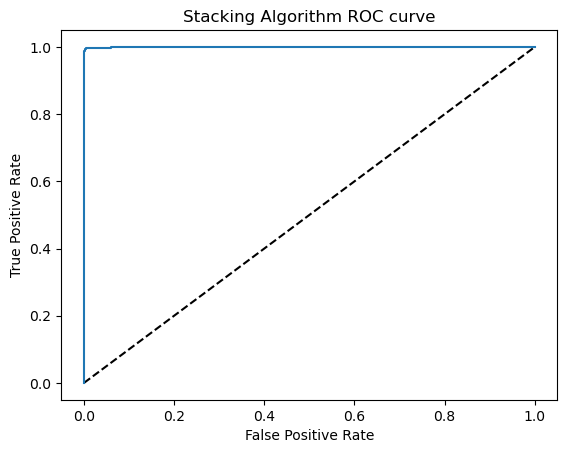

ROC-AUC score: 0.9998326898326898
Test PR-AUC (AP): 0.9997285126220509


In [378]:
meta_prob = grid_meta.predict_proba(Z_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, meta_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Stacking Algorithm ROC curve")
plt.show()
print("ROC-AUC score:", roc_auc_score(y_test, meta_prob))
print("Test PR-AUC (AP):", average_precision_score(y_test, meta_prob))

In [379]:
thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (meta_prob >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if p >= 0.90]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None 

print(f"Chosen threshold: {thr_star:.3f}  (Precision≥0.90)")
y_pred_thr = (meta_prob >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.020  (Precision≥0.90)
Precision/Recall/F1 @ thr: 0.9434306569343066 0.9980694980694981 0.9699812382739212
[[869  31]
 [  1 517]]


## Conclusion
The Stacking Algorithm and the Random Forest model alone are virtually equally precise and have equally high recall and PR-AUC for provided test dataset, with a slight advantage of the Random Forest model alone. 